In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from tabulate import tabulate
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

In [17]:
# Load dataset
data_path = '/fake_news_dataset.csv'
df = pd.read_csv(data_path, encoding='ascii', delimiter=',')

# Quick overview of the data
print('Dataset shape:', df.shape)
df.head()

Dataset shape: (4000, 24)


,id,title,author,text,state,date_published,source,category,sentiment_score,word_count,...,num_shares,num_comments,political_bias,fact_check_rating,is_satirical,trust_score,source_reputation,clickbait_score,plagiarism_score,label
0,1,Breaking News 1,Jane Smith,This is the content of article 1. It contains ...,Tennessee,30-11-2021,The Onion,Entertainment,-0.22,1302,...,47305,450,Center,FALSE,1,76,6,0.84,53.35,Fake
1,2,Breaking News 2,Emily Davis,This is the content of article 2. It contains ...,Wisconsin,02-09-2021,The Guardian,Technology,0.92,322,...,39804,530,Left,Mixed,1,1,5,0.85,28.28,Fake
2,3,Breaking News 3,John Doe,This is the content of article 3. It contains ...,Missouri,13-04-2021,New York Times,Sports,0.25,228,...,45860,763,Center,Mixed,0,57,1,0.72,0.38,Fake
3,4,Breaking News 4,Alex Johnson,This is the content of article 4. It contains ...,North Carolina,08-03-2020,CNN,Sports,0.94,155,...,34222,945,Center,TRUE,1,18,10,0.92,32.20,Fake
4,5,Breaking News 5,Emily Davis,This is the content of article 5. It contains ...,California,23-03-2022,Daily Mail,Technology,-0.01,962,...,35934,433,Right,Mixed,0,95,6,0.66,77.70,Real


In [18]:
df.tail()

,id,title,author,text,state,date_published,source,category,sentiment_score,word_count,...,num_shares,num_comments,political_bias,fact_check_rating,is_satirical,trust_score,source_reputation,clickbait_score,plagiarism_score,label
3995,3996,Breaking News 3996,John Doe,This is the content of article 3996. It contai...,Ohio,25-04-2020,InfoWars,Technology,0.91,1227,...,38880,697,Right,Mixed,0,29,10,0.22,95.46,Fake
3996,3997,Breaking News 3997,Alex Johnson,This is the content of article 3997. It contai...,Washington,09-01-2022,CNN,Sports,-0.57,1296,...,3650,925,Left,FALSE,1,53,3,0.42,16.54,Fake
3997,3998,Breaking News 3998,Alex Johnson,This is the content of article 3998. It contai...,California,03-03-2023,Breitbart,Entertainment,-0.17,522,...,35391,577,Left,FALSE,0,22,9,0.50,28.51,Fake
3998,3999,Breaking News 3999,John Doe,This is the content of article 3999. It contai...,Illinois,13-04-2021,New York Times,Health,-0.88,169,...,40424,201,Left,FALSE,1,3,6,0.17,71.16,Real
3999,4000,Breaking News 4000,John Doe,This is the content of article 4000. It contai...,Texas,20-12-2023,The Guardian,Health,-0.95,465,...,48913,279,Right,TRUE,1,73,4,0.09,27.65,Real


In [19]:
df.shape

(4000, 24)

In [20]:
df.isna().sum()

,0
id,0
title,0
author,0
text,0
state,0
date_published,0
source,0
category,0
sentiment_score,0
word_count,0


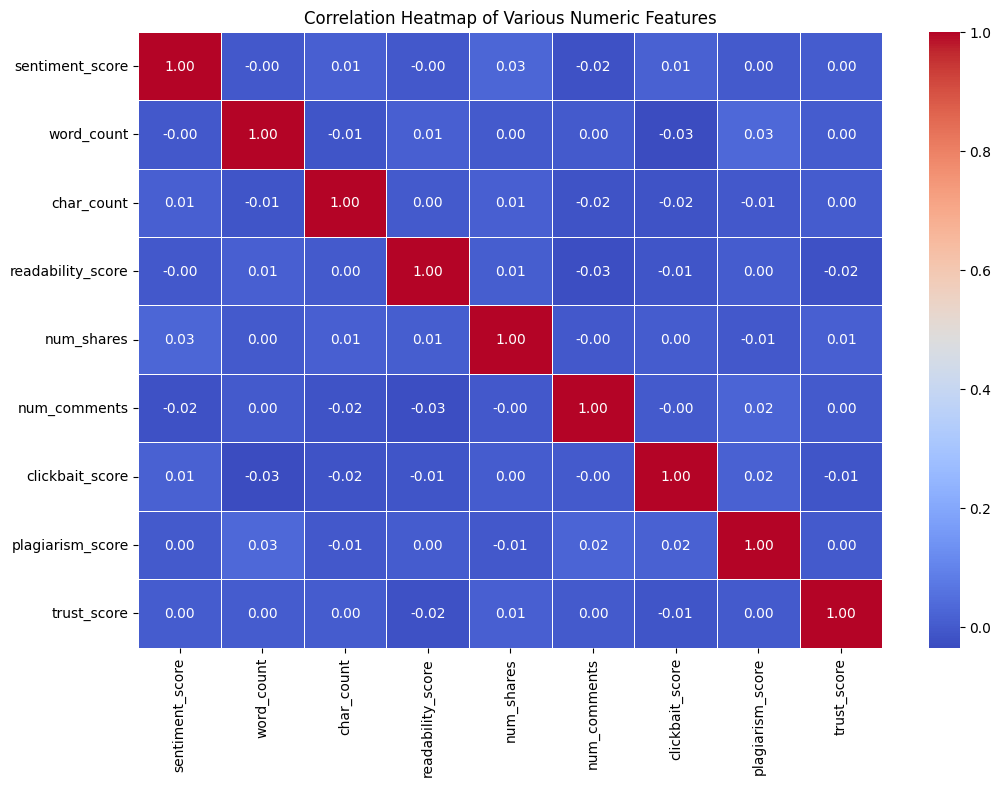

In [21]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df[['sentiment_score', 'word_count', 'char_count', 'readability_score',
                         'num_shares', 'num_comments', 'clickbait_score', 'plagiarism_score', 'trust_score']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Various Numeric Features')
plt.show()

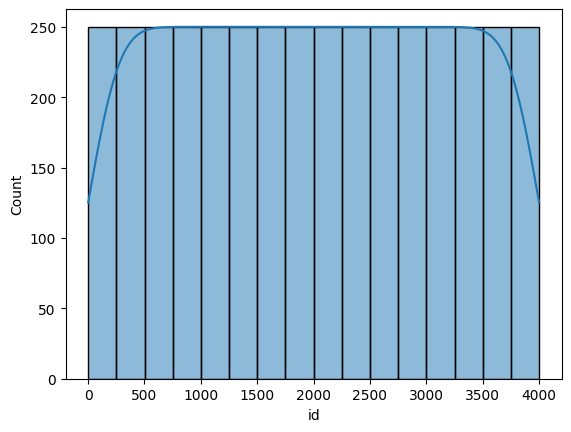

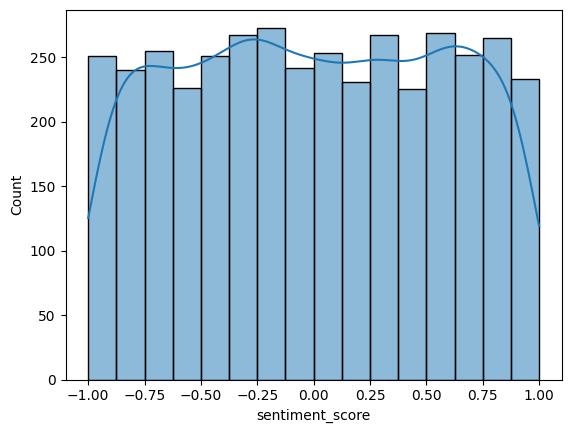

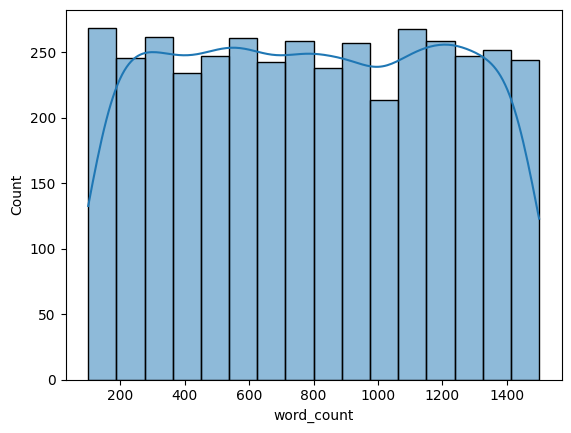

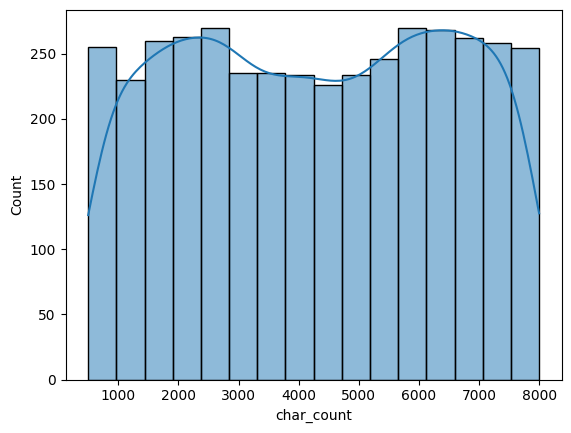

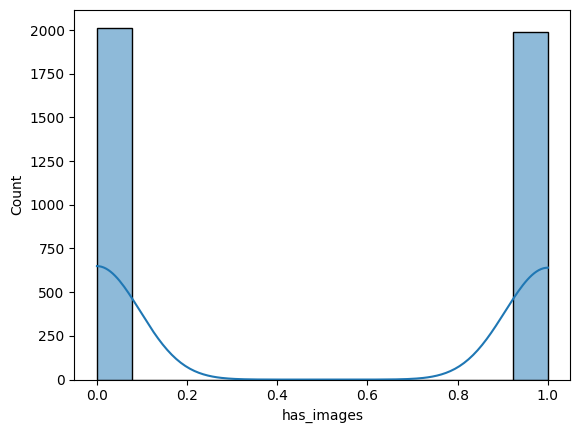

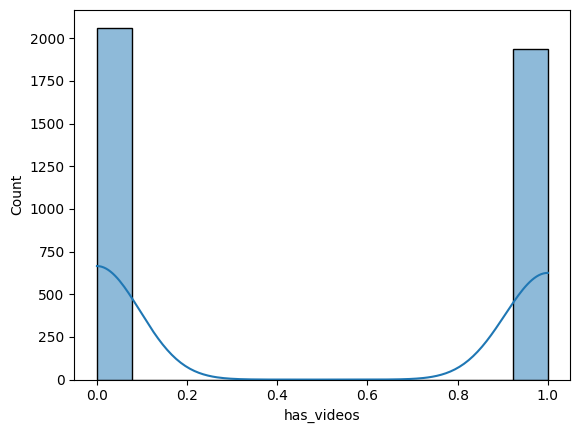

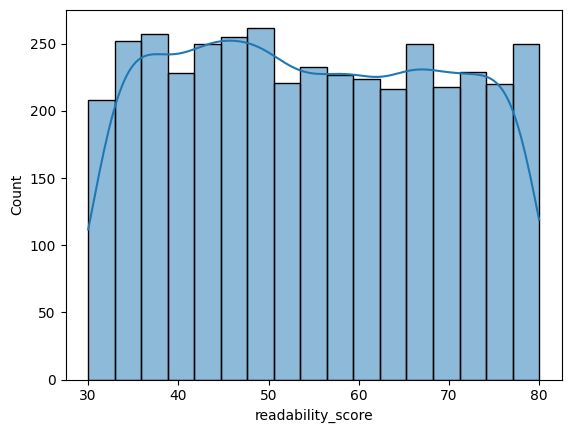

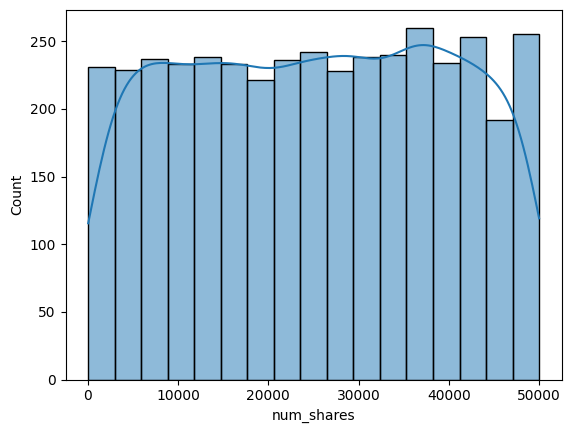

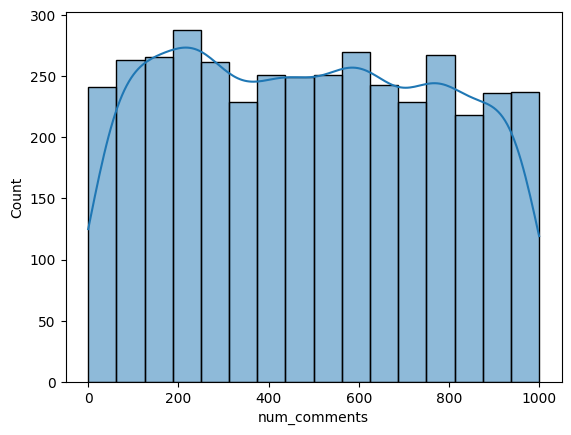

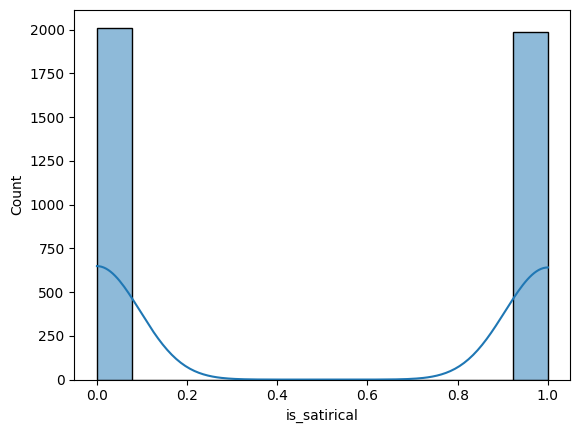

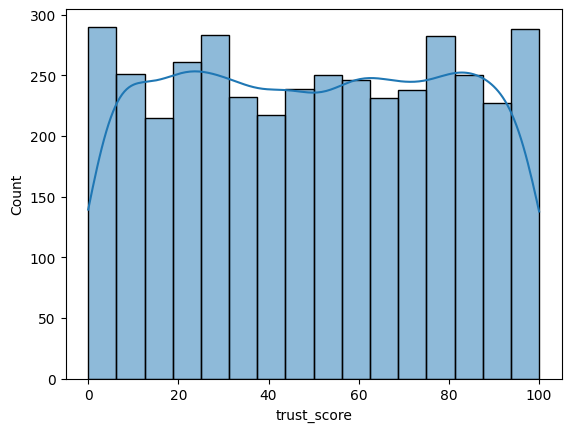

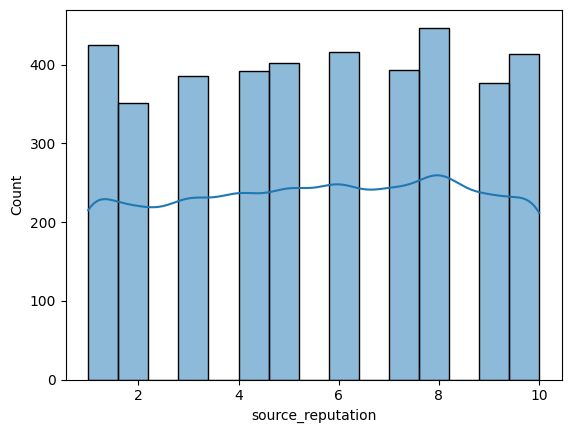

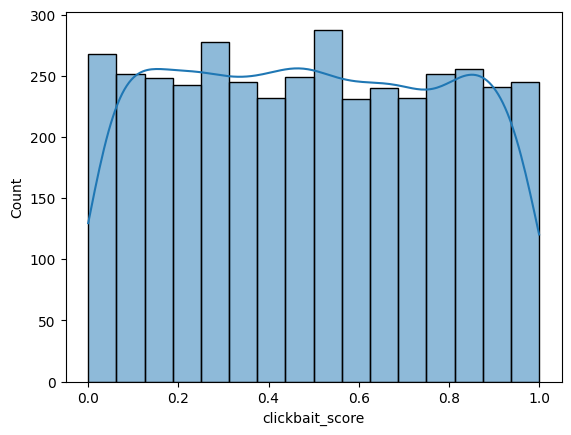

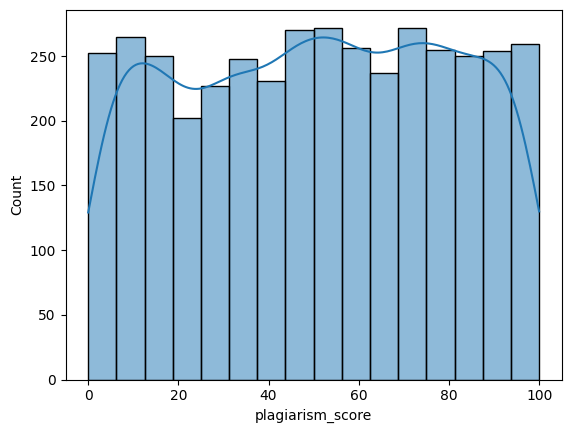

In [22]:
numeric_cols = df.select_dtypes(include=['number']).columns

# Distribution plot for each numeric column
for col in numeric_cols:
    sns.histplot(x=col, data=df, kde=True)
    plt.show()

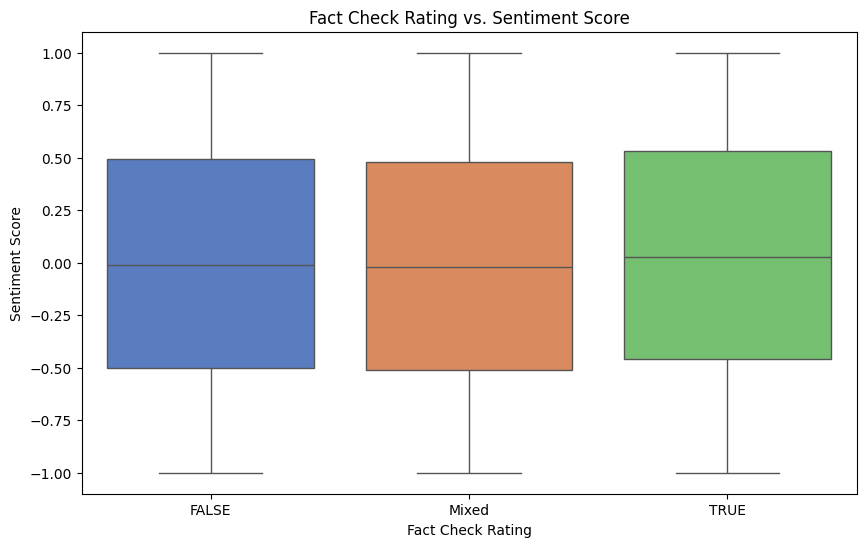

In [23]:
# Fact Check Rating vs. Sentiment Score
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='fact_check_rating', y='sentiment_score', palette='muted')
plt.title('Fact Check Rating vs. Sentiment Score')
plt.xlabel('Fact Check Rating')
plt.ylabel('Sentiment Score')
plt.show()

Descriptive statistics:
                id  sentiment_score   word_count  char_count  has_images  \
count  4000.000000      4000.000000  4000.000000   4000.0000  4000.00000   
mean   2000.500000        -0.000645   795.655750   4277.0680     0.49650   
std    1154.844867         0.574768   406.373871   2186.2073     0.50005   
min       1.000000        -1.000000   100.000000    500.0000     0.00000   
25%    1000.750000        -0.490000   445.750000   2358.7500     0.00000   
50%    2000.500000        -0.010000   793.000000   4287.0000     0.00000   
75%    3000.250000         0.510000  1150.000000   6206.5000     1.00000   
max    4000.000000         1.000000  1500.000000   7996.0000     1.00000   

        has_videos  readability_score    num_shares  num_comments  \
count  4000.000000        4000.000000   4000.000000   4000.000000   
mean      0.484500          54.764595  25144.596750    489.870250   
std       0.499822          14.404027  14387.537467    287.435733   
min       0.000

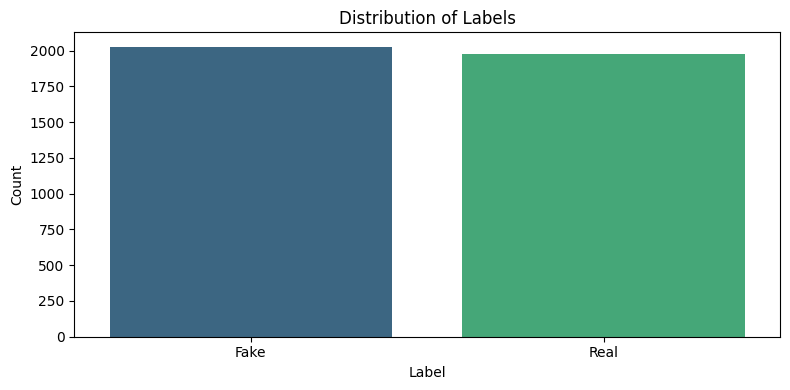

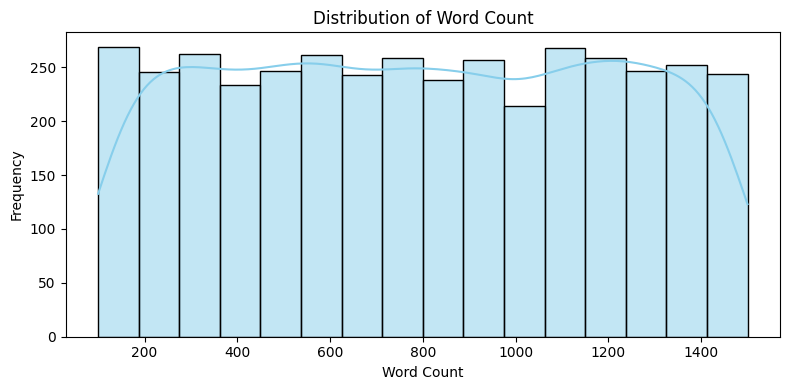

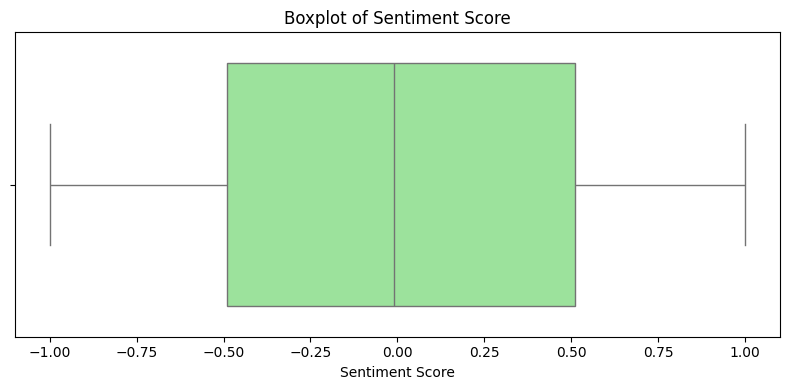

In [24]:
# Descriptive statistics for numeric features
print('Descriptive statistics:')
print(df.describe())

# Distribution of the target variable 'label'
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='label', palette='viridis')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Histogram for word_count
plt.figure(figsize=(8, 4))
sns.histplot(df['word_count'], kde=True, color='skyblue')
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Box Plot for sentiment_score
plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x='sentiment_score', color='lightgreen')
plt.title('Boxplot of Sentiment Score')
plt.xlabel('Sentiment Score')
plt.tight_layout()
plt.show()

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

Prediction Accuracy: 0.51875


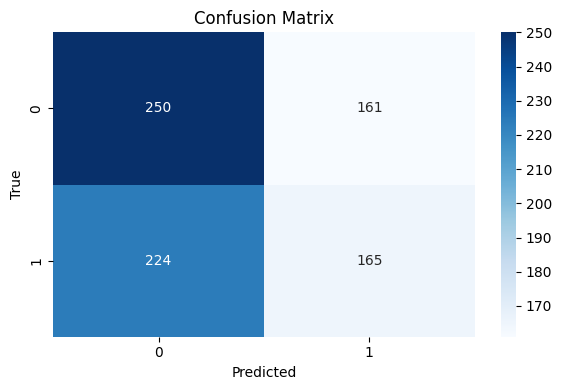

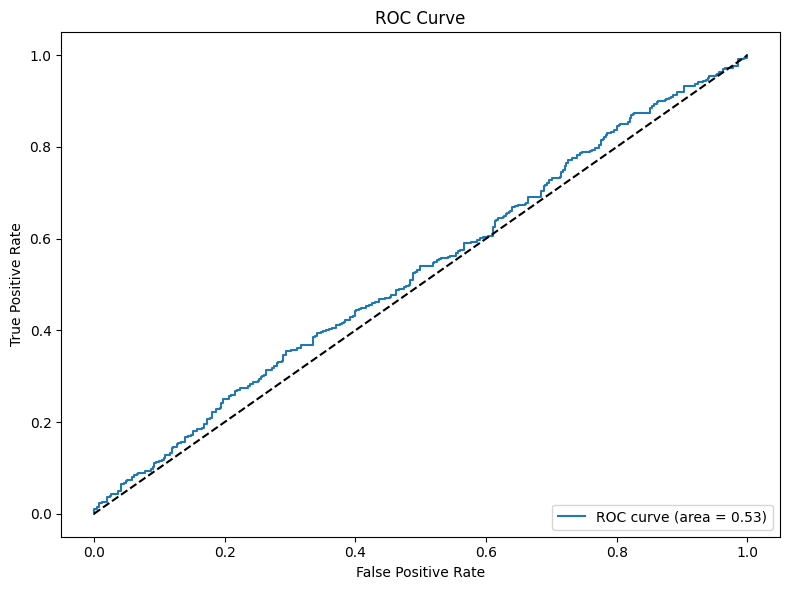

In [26]:
# Encode target variable 'label'
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Select features for modeling
features = ['sentiment_score', 'word_count', 'char_count', 'has_images', 'has_videos',
            'readability_score', 'num_shares', 'num_comments', 'trust_score',
            'source_reputation', 'clickbait_score', 'plagiarism_score']

# Define X and y
X = df[features]
y = df['label_encoded']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Make predictions and calculate accuracy
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Prediction Accuracy:', accuracy)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# ROC Curve
y_scores = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

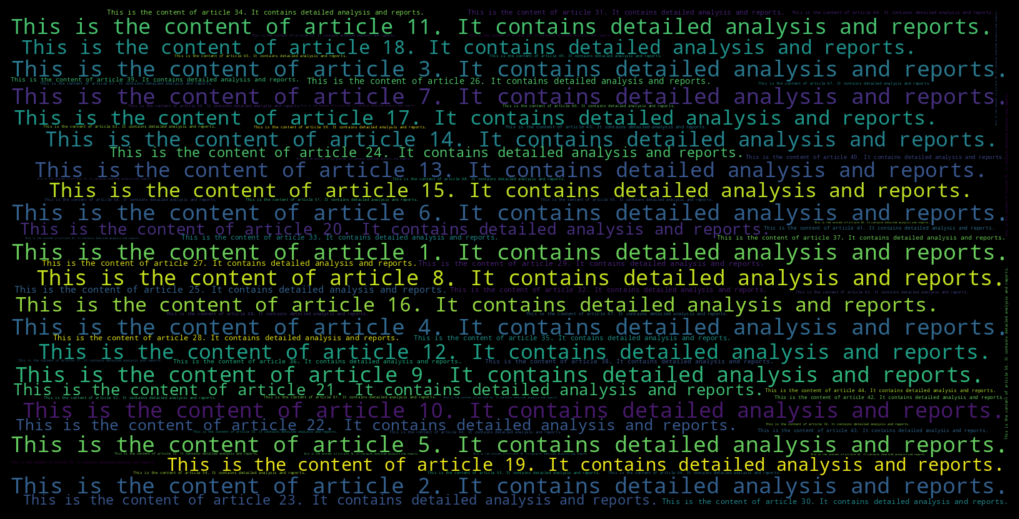

In [27]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import pandas as pd

# Assuming `dataset` is your DataFrame and `stop_words_list` is a list of stopwords

# Example stopwords list, modify as needed
stop_words_list = set(STOPWORDS)

# Generate frequency counts from the 'business_category' column
counts = Counter(df["text"].dropna().apply(lambda x: str(x)))

# Generate the word cloud
wcc = WordCloud(
    background_color="black",
    width=1600, height=800,
    max_words=2000,
    stopwords=stop_words_list
)
wcc.generate_from_frequencies(counts)

# Display the word cloud
plt.figure(figsize=(10, 5), facecolor='k')
plt.imshow(wcc, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()